In [1]:
import opendatasets as od

In [3]:
od.download('https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading ravdess-emotional-speech-audio.zip to .\ravdess-emotional-speech-audio


100%|██████████| 429M/429M [02:02<00:00, 3.68MB/s] 


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
folder_path="D:/speech_recognition/ravdess/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
x= os.listdir(folder_path)
emotion=[]
file_path=[]
for i in x:
  filename= os.listdir(folder_path+ i)
  for f in filename:
    """Filename is a 7-part unique string. eg: 03-01-06-01-02-01-12.wav 
    Filename identifiers
    
    --> Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

    --> Vocal channel (01 = speech, 02 = song).

    --> Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

    --> Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

    --> Statement (01 = "Kids are talking by the door", 02 = ["Dogs are sitting by the door").

    --> Repetition (01 = 1st repetition, 02 = 2nd repetition).

    --> Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

    """
    filename_identifiers = f.split('.')[0].split('-')
    emotion.append(int(filename_identifiers[2]))
    file_path.append(folder_path + i + '/' + f)
RAVDESS_df = pd.DataFrame(emotion)
RAVDESS_df = RAVDESS_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAVDESS_df.columns = ['emotion']
RAVDESS_df = pd.concat([RAVDESS_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)

In [9]:
RAVDESS_df

,emotion,path
0,neutral,D:/speech_recognition/ravdess/ravdess-emotiona...
1,neutral,D:/speech_recognition/ravdess/ravdess-emotiona...
2,neutral,D:/speech_recognition/ravdess/ravdess-emotiona...
3,neutral,D:/speech_recognition/ravdess/ravdess-emotiona...
4,calm,D:/speech_recognition/ravdess/ravdess-emotiona...
...,...,...
1435,surprise,D:/speech_recognition/ravdess/ravdess-emotiona...
1436,surprise,D:/speech_recognition/ravdess/ravdess-emotiona...
1437,surprise,D:/speech_recognition/ravdess/ravdess-emotiona...
1438,surprise,D:/speech_recognition/ravdess/ravdess-emotiona...


<AxesSubplot: >

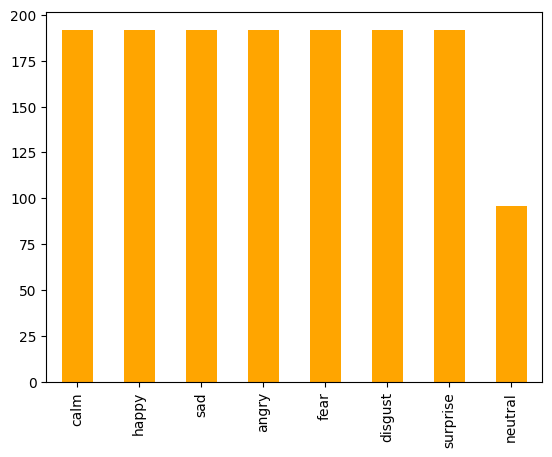

In [10]:
RAVDESS_df.emotion.value_counts().plot(kind='bar', color='orange')

In [11]:
import librosa

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [12]:
def extract_features(data,sample_rate):
    
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) 

    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) 

    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 

    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) 

    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    
    return result

def get_features(path):
    
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    res1 = extract_features(data,sample_rate)
    result = np.array(res1)
    
    noise_data = noise(data)
    res2 = extract_features(noise_data,sample_rate )
    result = np.vstack((result, res2)) 
    
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3))
    
    return result

In [13]:
X, Y = [], []
for path, emotion in zip(RAVDESS_df.path, RAVDESS_df.emotion):
    features = get_features(path)
    for i in features:
        X.append(i)
        Y.append(emotion)

C:\Users\Manav\AppData\Local\Temp\ipykernel_17092\1313063952.py:9: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data, rate)
C:\Users\Manav\AppData\Local\Temp\ipykernel_17092\1313063952.py:16: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


In [14]:
RAVDESS_df = pd.DataFrame(X)
RAVDESS_df['emotion'] = Y
RAVDESS_df.to_csv('features.csv', index=False)
RAVDESS_df

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,emotion
0,0.283226,0.739174,0.760110,0.738748,0.712194,0.687986,0.667279,0.694000,0.742275,0.762594,...,4.312694e-06,3.293364e-06,2.149553e-06,2.260914e-06,4.562520e-06,4.985617e-06,1.324619e-06,1.469305e-07,3.053402e-09,neutral
1,0.270603,0.753641,0.782510,0.765907,0.763369,0.754773,0.676917,0.677510,0.726546,0.758329,...,4.869298e-06,3.931754e-06,2.869216e-06,2.984439e-06,5.350939e-06,5.816084e-06,2.026702e-06,8.025134e-07,6.556192e-07,neutral
2,0.181467,0.629995,0.730929,0.743651,0.680889,0.670727,0.673700,0.669033,0.709932,0.745144,...,8.582505e-07,9.570446e-07,7.741540e-07,5.212421e-07,3.252106e-07,4.883136e-07,2.353670e-07,2.240905e-08,9.753157e-11,neutral
3,0.254530,0.676571,0.724970,0.725722,0.668644,0.645344,0.671471,0.631493,0.681748,0.709889,...,6.987414e-06,7.038922e-06,6.659573e-06,6.937638e-06,1.117492e-05,5.767251e-06,2.024577e-06,1.944936e-07,2.701240e-09,neutral
4,0.265449,0.735037,0.763969,0.744755,0.724998,0.736736,0.674815,0.636886,0.690838,0.721025,...,8.080088e-06,8.097283e-06,7.685010e-06,8.212931e-06,1.270355e-05,6.975177e-06,3.103464e-06,1.324152e-06,1.129759e-06,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,0.336964,0.702839,0.737097,0.746860,0.769672,0.797361,0.733673,0.684364,0.638615,0.645215,...,1.129226e-02,1.235735e-02,1.091163e-02,1.212277e-02,1.112212e-02,9.371398e-03,6.707440e-03,5.487463e-03,5.441313e-03,surprise
4316,0.202478,0.629530,0.614888,0.619483,0.590790,0.544241,0.576305,0.640321,0.604377,0.535951,...,1.667408e-03,1.416626e-03,1.331452e-03,1.620398e-03,1.240587e-03,8.613643e-04,2.522190e-04,1.130696e-05,1.081271e-07,surprise
4317,0.210797,0.679064,0.616295,0.591611,0.544438,0.524399,0.566287,0.588380,0.638773,0.644580,...,5.657441e-03,4.143015e-03,3.528072e-03,2.774585e-03,2.309308e-03,1.547166e-03,4.988715e-04,3.767123e-05,5.711440e-07,surprise
4318,0.268573,0.685580,0.669879,0.666565,0.646347,0.623967,0.644324,0.623503,0.644090,0.678625,...,5.764592e-03,4.241999e-03,3.635203e-03,2.849168e-03,2.394150e-03,1.676238e-03,6.303350e-04,1.524107e-04,1.086751e-04,surprise


In [15]:
from sklearn.model_selection import train_test_split
X = RAVDESS_df.drop(['emotion'], axis=1)
feature_names = list(X.columns)
X = X.values
labels = np.sort(np.unique(RAVDESS_df.emotion.values))
index = {}
val = {}
for i, j in enumerate(labels):
    index[j] = i
    val[i] = j
y = np.array([index[x] for x in RAVDESS_df.emotion.values])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svclassifier = SVC()
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
acc = float(accuracy_score(y_test,y_pred))*100
print("Accuracy Score is:", acc)

Accuracy Score is: 29.166666666666668


c:\Users\Manav\anaconda3\envs\tf2.11\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


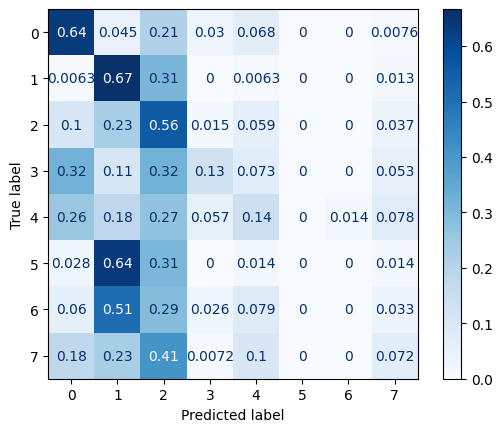

In [17]:
from sklearn.metrics import plot_confusion_matrix
matrix = plot_confusion_matrix(svclassifier,X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.show(matrix)
plt.show()

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
acc = float(accuracy_score(y_test,y_pred))*100
print("Accuracy Score is:", acc)

Accuracy Score is: 45.370370370370374


c:\Users\Manav\anaconda3\envs\tf2.11\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


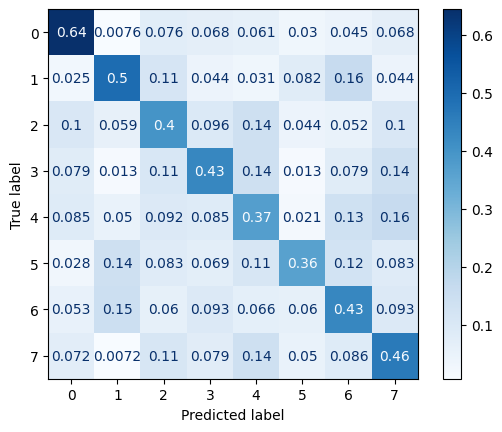

In [19]:
from sklearn.metrics import plot_confusion_matrix
matrix = plot_confusion_matrix(decision_tree,X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.show(matrix)
plt.show()

In [20]:
import keras
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical 

In [21]:
X = RAVDESS_df.iloc[: ,:-1].values
Y = RAVDESS_df['emotion'].values

In [22]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [25]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(loss = tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse"), tf.keras.metrics.BinaryAccuracy(name="accuracy")], optimizer = tf.keras.optimizers.Adam(1e-4))

In [27]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_acc', mode='max', verbose=1)
history= model.fit(x_train, y_train, epochs = 20, batch_size = 32, callbacks=[callback])

Epoch 1/20
102/102 [==============================] - ETA: 0s - loss: 0.1128 - rmse: 0.3359 - accuracy: 0.8750
Epoch 1: saving model to best_model.h5
102/102 [==============================] - 53s 63ms/step - loss: 0.1128 - rmse: 0.3359 - accuracy: 0.8750
Epoch 2/20
102/102 [==============================] - ETA: 0s - loss: 0.1097 - rmse: 0.3312 - accuracy: 0.8750
Epoch 2: saving model to best_model.h5
102/102 [==============================] - 9s 84ms/step - loss: 0.1097 - rmse: 0.3312 - accuracy: 0.8750
Epoch 3/20
102/102 [==============================] - ETA: 0s - loss: 0.1096 - rmse: 0.3311 - accuracy: 0.8750
Epoch 3: saving model to best_model.h5
102/102 [==============================] - 10s 95ms/step - loss: 0.1096 - rmse: 0.3311 - accuracy: 0.8750
Epoch 4/20
102/102 [==============================] - ETA: 0s - loss: 0.1096 - rmse: 0.3311 - accuracy: 0.8750
Epoch 4: saving model to best_model.h5
102/102 [==============================] - 10s 97ms/step - loss: 0.1096 - rmse: 0.3

In [28]:
score = model.evaluate(x_test, y_test)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100,"%")

34/34 [==============================] - 3s 31ms/step - loss: 0.1094 - rmse: 0.3307 - accuracy: 0.8750
Test Loss: 0.10938487946987152
Test accuracy: 33.07338356971741 %


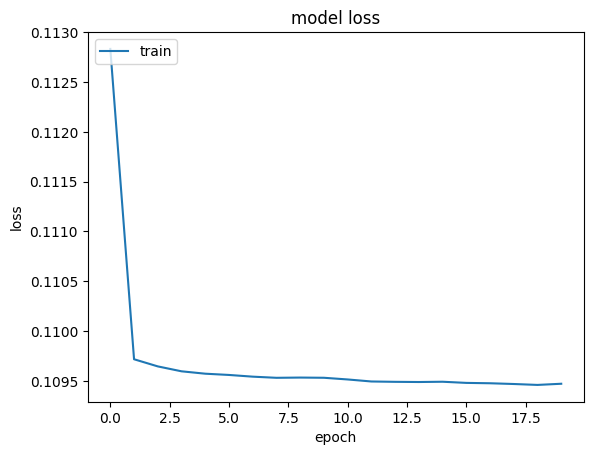

In [29]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

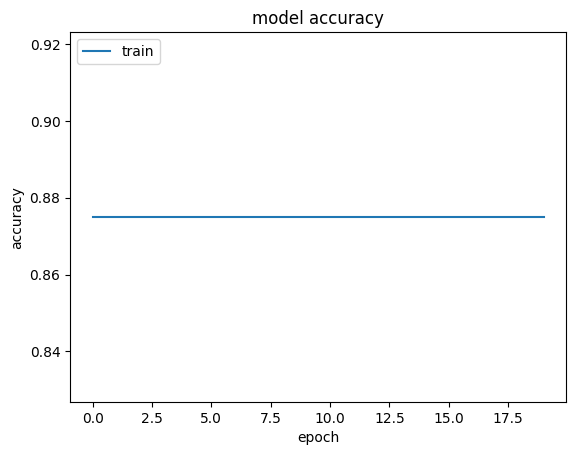

In [30]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()